<a href="https://colab.research.google.com/github/shravankumar147/ComputerVision-LLMs-Research/blob/master/hf/vlms/Qwen2_VL_2B_Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Ref: https://huggingface.co/Qwen/Qwen2-VL-2B-Instruct

# Observations:
--------------

##  1. On T4 GPU

When tried the Qwen2.5 model,

```

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
    device_map="auto",
)
```

        Got RuntimeError: FlashAttention only supports Ampere GPUs or newer.
    
    
So let's not use Flash Attention

## 2. OutOfMemoryError: CUDA out of memory.

```
OutOfMemoryError: CUDA out of memory. Tried to allocate 12.20 GiB. GPU 0 has a total capacity of 14.75 GiB of which 8.83 GiB is free. Process 145597 has 5.92 GiB memory in use. Of the allocated memory 5.38 GiB is allocated by PyTorch, and 420.33 MiB is reserved by PyTorch but unallocated.
```

T4 GPU - 15GB inline with

        GPU 0 has a total capacity of 14.75 GiB

This is verified on Model loading, both on Resources (attached screenshot, aswells as memory summary)
        
        Process 145597 has 5.92 GiB memory in use

14.75 - 5.92 = 8.83.

        8.83 GiB is free

is also validated.

It seems we need more 12-13 GiB memory.
        
        Tried to allocate 12.20 GiB


        12.20 - 8.83 = 3.37

        more memory is needed.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers qwen-vl-utils  quanto accelerate
# flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch
torch.cuda.empty_cache()
gpu_summary = torch.cuda.memory_summary(device=0)  # To verify free memory

KeyError: 'allocated_bytes.all.current'

In [ ]:
print(gpu_summary)

In [4]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info


In [5]:

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto"
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-2B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-2B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.20 GiB. GPU 0 has a total capacity of 14.75 GiB of which 8.83 GiB is free. Process 145597 has 5.92 GiB memory in use. Of the allocated memory 5.38 GiB is allocated by PyTorch, and 420.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

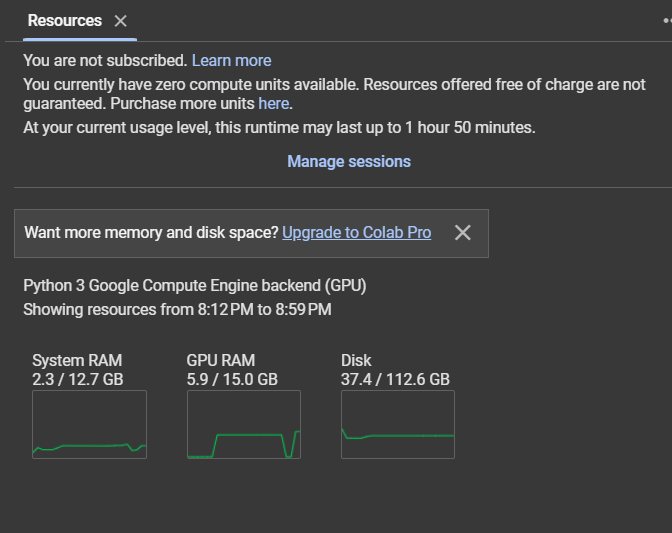

The above is the resource utilization

In [7]:
gpu_summary = torch.cuda.memory_summary(device=0)  # To verify free memory
print(gpu_summary)

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   4773 MiB |   5513 MiB |   6509 MiB |   1735 MiB |
|       from large pool |   4729 MiB |   5470 MiB |   6464 MiB |   1734 MiB |
|       from small pool |     43 MiB |     44 MiB |     45 MiB |      1 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   4773 MiB |   5513 MiB |   6509 MiB |   1735 MiB |
|       from large pool |   4729 MiB |   5470 MiB |   6464 MiB |

In [8]:
def mib_to_gib(mib_value):
    return round(mib_value / 1024, 2)

print("GPU Memory Summary (in GiB):")
lines = gpu_summary.strip().split("\n")
for line in lines:
    if "MiB" in line:
        parts = line.split("|")
        converted = [
            f"{mib_to_gib(float(value.split()[0]))} GiB" if "MiB" in value else value
            for value in parts
        ]
        print("|".join(converted))
    else:
        print(line)

GPU Memory Summary (in GiB):
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |4.66 GiB|5.38 GiB|6.36 GiB|1.69 GiB|
|       from large pool |4.62 GiB|5.34 GiB|6.31 GiB|1.69 GiB|
|       from small pool |0.04 GiB|0.04 GiB|0.04 GiB|0.0 GiB|
|---------------------------------------------------------------------------|
| Active memory         |4.66 GiB|5.38 GiB|6.36 GiB|1.69 GiB|
|       from large pool |4.62 GiB|5.34 GiB|6.31 GiB|1.69 GiB|
|       from small pool |0.04 GiB|0.04